In [133]:
# Import Packages

import pandas as pd
import sqlite3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns


# 2025-05-01, Link Checker Report for All Units

### Data Source

This report accesssed **Voyager** via **reportsdb.library.yale.edu**. 

### Voyager Tables and Columns Queried
               
    - bib_master.bib_id
    - elink_index.url_host
    - elink_index.link
    - location.location_code
    - bib_mfhd.bib_id
    - mfhd_master.location_id
    - location.location_id
                 

### Voyager Locations Queried

- 'ART' 
- 'BASS' 
- 'BEINECKE' 
- 'CLASSICS' 
- 'DIV' 
- 'FILM' 
- 'MARCIVE' 
- 'MARX' 
- 'MEDICAL' 
- 'MICRO' 
- 'MSSA' 
- 'MUSIC' 
- 'WALPOLE' 
- 'YCBA' 
- 'CHI',
- 'JPN' 
- 'HEB' 
- 'SEA' 
- 'SEE' 
- 'SML' 
- 'TS' 
- 'MFHD_WALPOLE' 
- 'MFHD_MSSA' 
- "IA"



In [ ]:
# Connect to Database
conn = sqlite3.connect("/Users/if224/Documents/rds_git_repos/link_checker/link_checker.db")
print(f"Database connected")

# Total Links and Errors from all units

In [135]:
query = """
SELECT 
    COUNT(*) AS Total_Links,
    SUM(CASE WHEN Status != '200' THEN 1 ELSE 0 END) AS Total_Errors
FROM (
    SELECT DISTINCT BibID, URL, Status
    FROM bib_url_status_report
) AS unique_links;

"""

totals_df = pd.read_sql_query(query, conn)
totals_df

,Total_Links,Total_Errors
0,247171,32773


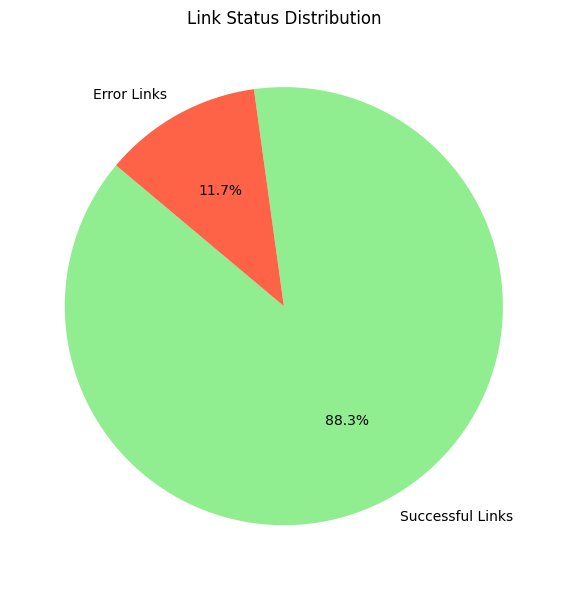

In [137]:
total_links = totals_df['Total_Links'].iloc[0]
total_errors = totals_df['Total_Errors'].iloc[0]

# Define the pie chart data
pie_labels = ['Successful Links', 'Error Links']
pie_values = [total_links, total_errors]
colors = ['lightgreen', 'tomato']

# Create and display the pie chart
plt.figure(figsize=(6, 6))
plt.pie(pie_values, labels=pie_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Link Status Distribution')
plt.tight_layout()
plt.show()

# Links and Errors by Library Unit

In [138]:
# Count Total Links and Errors by Unit
query = """
SELECT 
    unit,
    COUNT(*) AS Total_Links,
    SUM(CASE WHEN status != '200' THEN 1 ELSE 0 END) AS Total_Errors
FROM (
    SELECT 
        id, 
        unit, 
        bibid, 
        url, 
        status, 
        ROW_NUMBER() OVER (
            PARTITION BY bibid, url, unit
            ORDER BY check_date DESC
        ) AS rn 
    FROM bib_url_status_report
)
WHERE rn = 1
GROUP BY unit
ORDER BY Total_Errors DESC;

            """

count_by_units = pd.read_sql_query(query, conn)

count_by_units

,unit,Total_Links,Total_Errors
0,MARCIVE,54924,1553
1,ART,6691,1471
2,MSSA,4252,823
3,MARX,15985,678
4,YCBA,2912,557
5,SML,57137,519
6,DIV,10495,429
7,HEB,792,293
8,BEINECKE,32841,203
9,JPN,1351,199


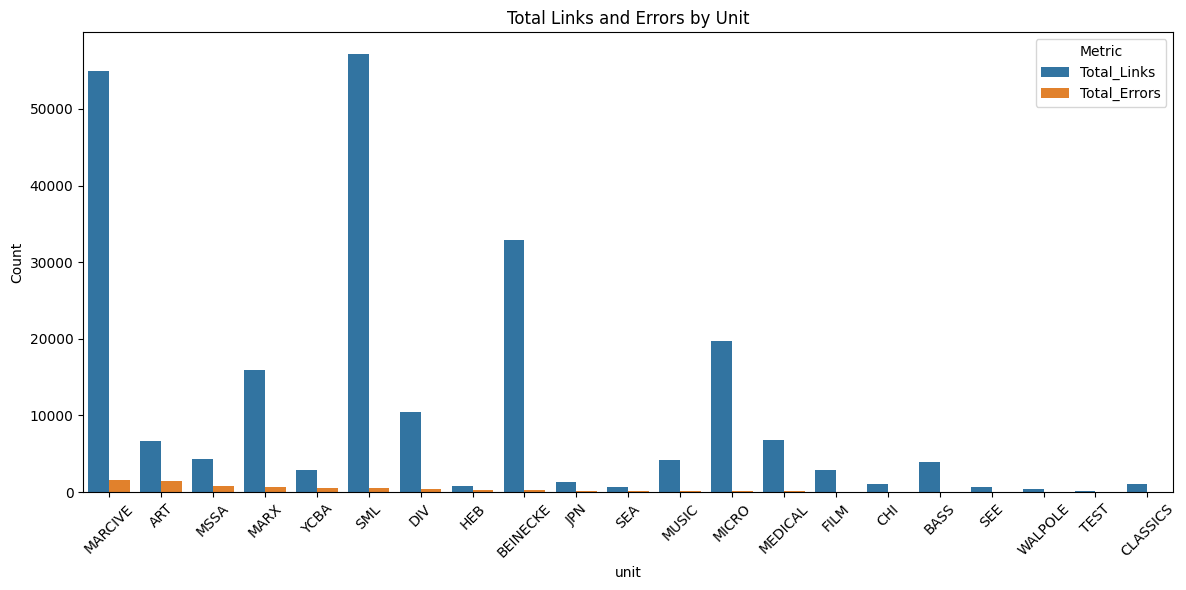

In [139]:
# Bar Chart: Total Links and Errors by Unit

# Melt dataframe to long format for seaborn
df_melted = count_by_units.melt(id_vars='unit', value_vars=['Total_Links', 'Total_Errors'],
                                 var_name='Metric', value_name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='unit', y='Count', hue='Metric')
plt.title('Total Links and Errors by Unit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Links and Errors by Domain

In [140]:
# Count Total Links and Errors by Domain
query = """SELECT 
    Domain,
    COUNT(*) AS Total_Links,
    SUM(CASE WHEN Status != '200' THEN 1 ELSE 0 END) AS Total_Errors
FROM bib_url_status_report
WHERE Check_Date IN (
    SELECT MAX(Check_Date)
    FROM bib_url_status_report
    GROUP BY Unit
)
GROUP BY Domain
ORDER BY Total_Errors DESC"""

error_by_domain = pd.read_sql_query(query, conn)
error_by_domain

,Domain,Total_Links,Total_Errors
0,www.loc.gov,56722,1831
1,purl.access.gpo.gov,57696,1031
2,ilibri.casalini.it,502,419
3,libraries.casalini.it,808,372
4,www.columbia.edu,284,279
...,...,...,...
2370,23sandy.com,1,0
2371,212berlin.com,1,0
2372,0-link.gale.com.catalogue.libraries.london.ac.uk,1,0
2373,0-galenet.galegroup.com.catalogue.libraries.lo...,39,0


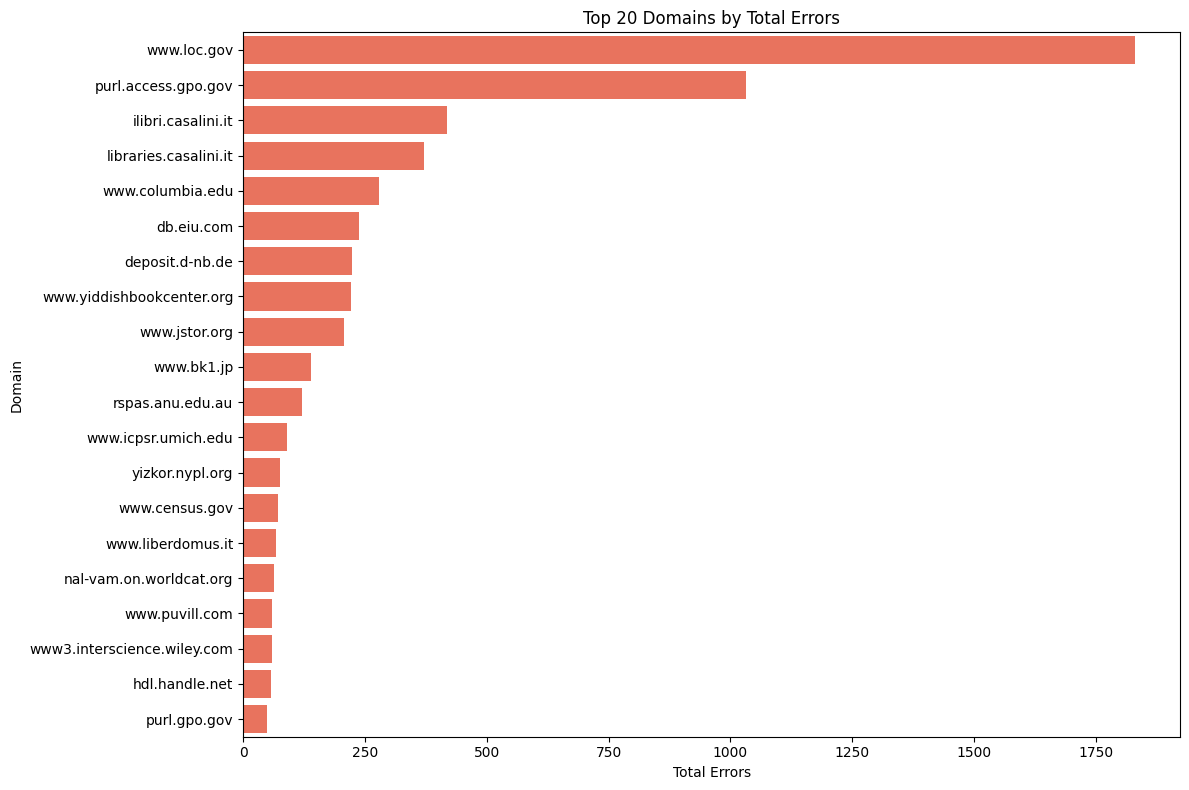

In [141]:
# Horizontal Bar Chart: Top 20 Domains by Total Errors

# Filter to top 20 domains by Total_Errors
top_domains = error_by_domain.sort_values(by='Total_Errors', ascending=False).head(20)

# Set up the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_domains, y='Domain', x='Total_Errors', color='tomato')

# Labels and title
plt.title('Top 20 Domains by Total Errors')
plt.xlabel('Total Errors')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()


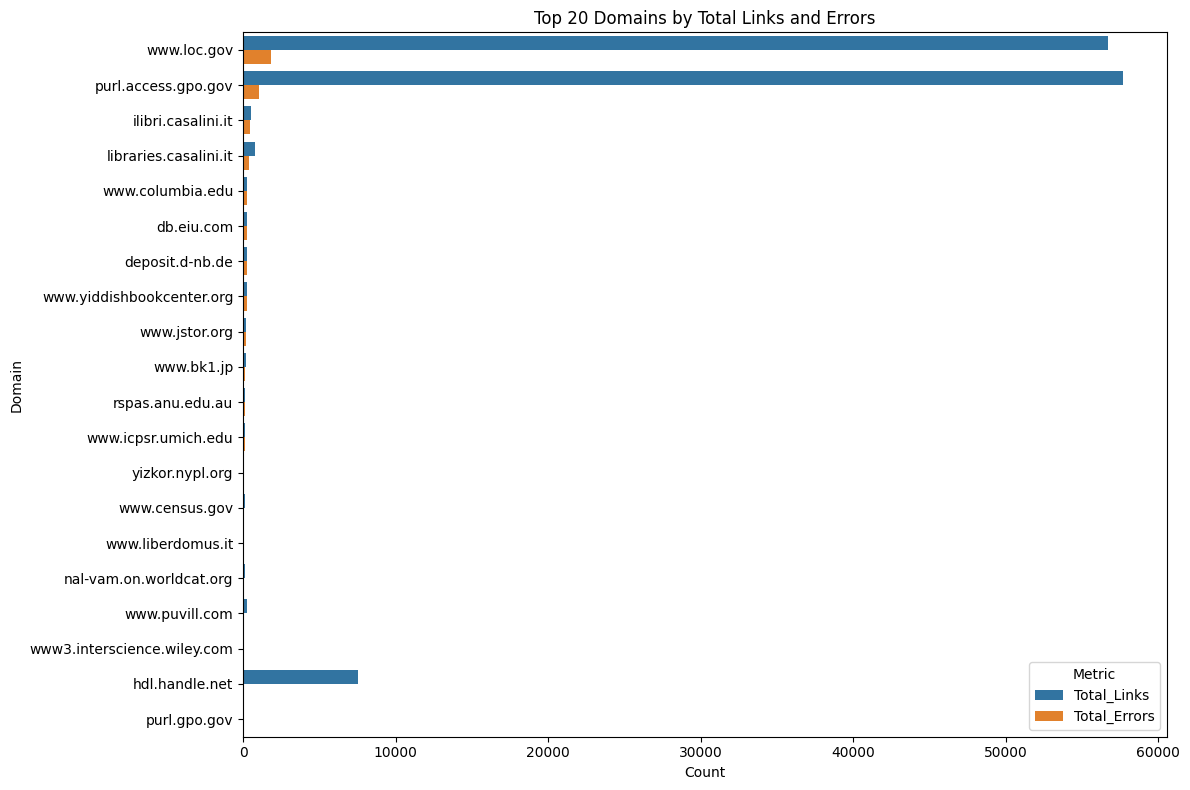

In [142]:
# Compare Total Links vs Total Errors per domain
# Melt the dataframe to long format
df_melted = top_domains.melt(id_vars='Domain', 
                             value_vars=['Total_Links', 'Total_Errors'], 
                             var_name='Metric', 
                             value_name='Count')

plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, y='Domain', x='Count', hue='Metric')
plt.title('Top 20 Domains by Total Links and Errors')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()


# Error Types
Group by the Status column and show frequency.

In [143]:
# Get Most Frequent Status Codes

query = """
SELECT Status, COUNT(*) AS Count
FROM bib_url_status_report
WHERE Check_Date IN (
    SELECT MAX(Check_Date)
    FROM bib_url_status_report
    GROUP BY Unit
)
GROUP BY Status
ORDER BY Count DESC
"""

most_frequent_status_code = pd.read_sql_query(query, conn)

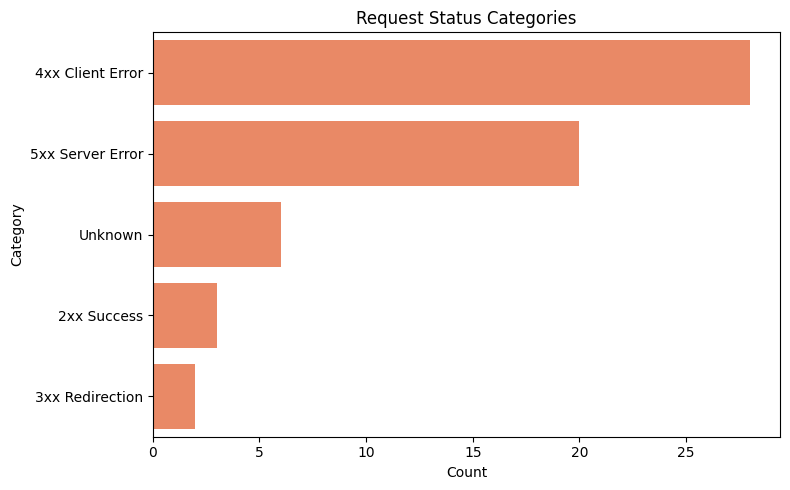

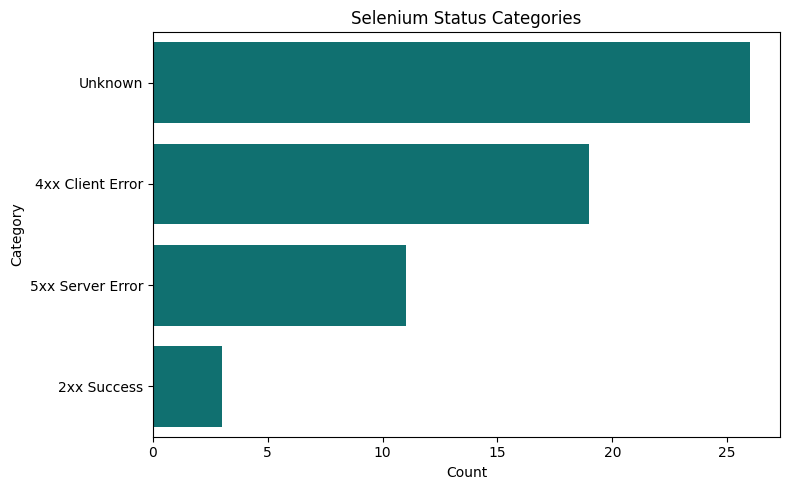

In [144]:
# Bar Chart: Top 15 Status Codes by Frequency

# 1. Parse status
def parse_status(status):
    try:
        parsed = json.loads(status)
        return parsed.get("requests", None), parsed.get("selenium", None)
    except:
        return status, status

most_frequent_status_code[['Requests_Status', 'Selenium_Status']] = most_frequent_status_code['Status'].apply(
    lambda x: pd.Series(parse_status(x))
)

# 2. Categorize status codes
def categorize_status(code):
    try:
        code = int(str(code)[:3])  # Ensure it's a 3-digit number
        if 100 <= code < 200:
            return '1xx Informational'
        elif 200 <= code < 300:
            return '2xx Success'
        elif 300 <= code < 400:
            return '3xx Redirection'
        elif 400 <= code < 500:
            return '4xx Client Error'
        elif 500 <= code < 600:
            return '5xx Server Error'
        else:
            return 'Other'
    except:
        return 'Unknown'

most_frequent_status_code['Requests_Category'] = most_frequent_status_code['Requests_Status'].apply(categorize_status)
most_frequent_status_code['Selenium_Category'] = most_frequent_status_code['Selenium_Status'].apply(categorize_status)

# 3. Count categories
req_cat_counts = most_frequent_status_code['Requests_Category'].value_counts().reset_index()
req_cat_counts.columns = ['Category', 'Count']

sel_cat_counts = most_frequent_status_code['Selenium_Category'].value_counts().reset_index()
sel_cat_counts.columns = ['Category', 'Count']

# 4. Plot - Requests Category
plt.figure(figsize=(8, 5))
sns.barplot(data=req_cat_counts, x='Count', y='Category', color='coral')
plt.title('Request Status Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# 5. Plot - Selenium Category
plt.figure(figsize=(8, 5))
sns.barplot(data=sel_cat_counts, x='Count', y='Category', color='teal')
plt.title('Selenium Status Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()



In [145]:
query = """
SELECT 
    Domain,
    Status,
    COUNT(*) AS Error_Count
FROM bib_url_status_report
WHERE Status != '200'
AND Check_Date IN (
    SELECT MAX(Check_Date)
    FROM bib_url_status_report
    GROUP BY Unit
)
GROUP BY Domain, Status
ORDER BY Domain, Error_Count DESC
"""

domain_error_types = pd.read_sql_query(query, conn)


In [146]:
# Get Top N Domains by Total Errors
top_n = 10  # or 10, 20...
top_domains = (
    domain_error_types.groupby('Domain')['Error_Count']
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index
)


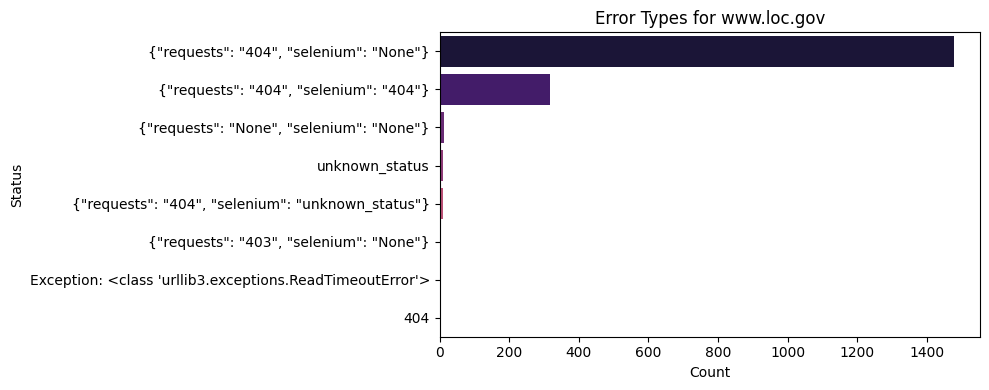

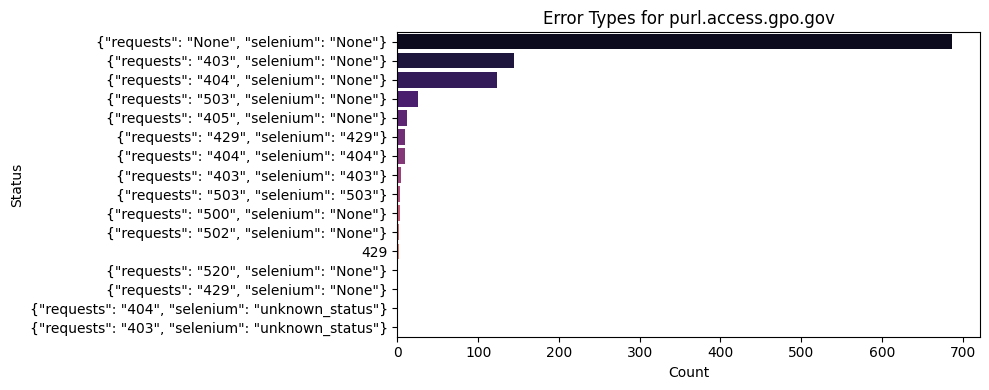

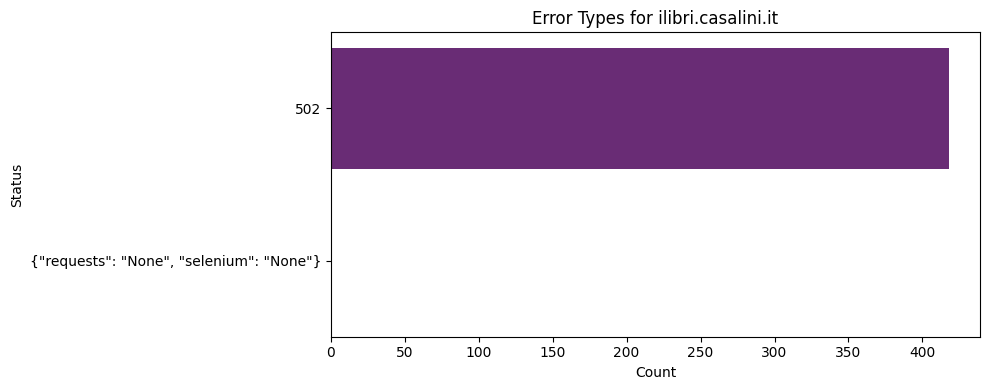

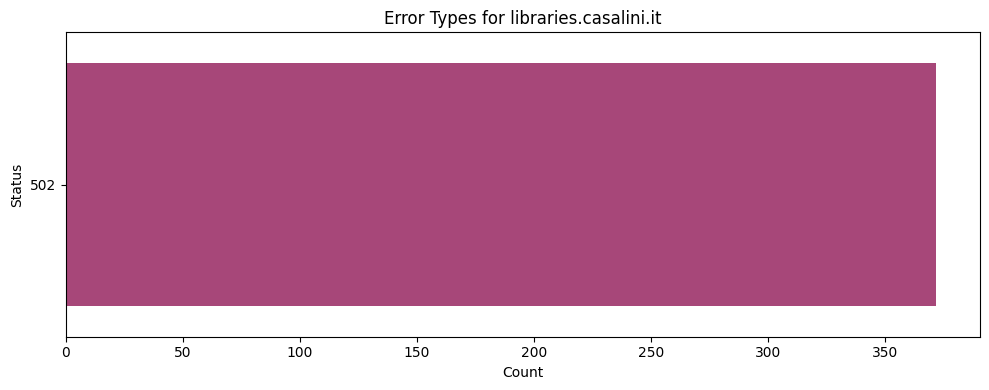

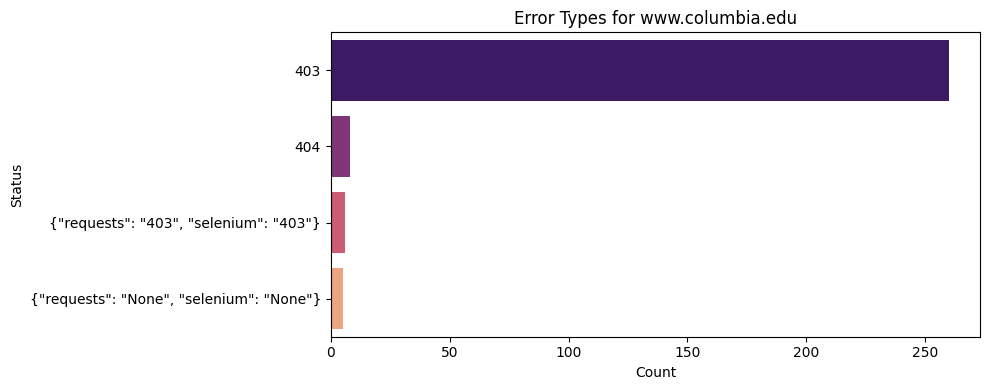

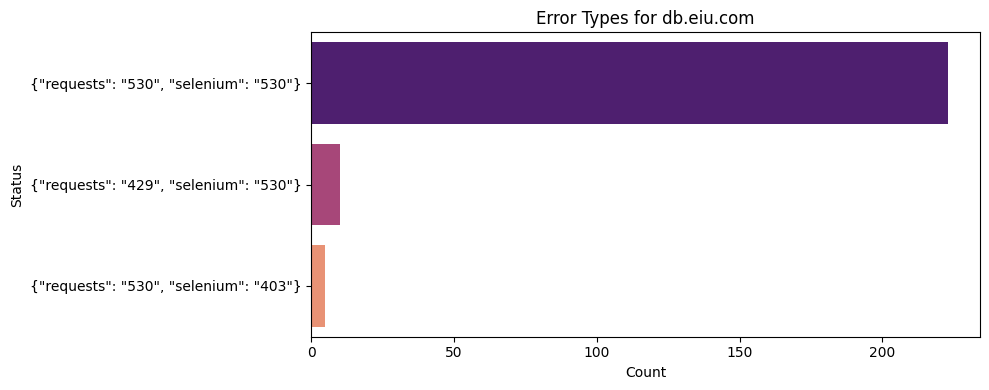

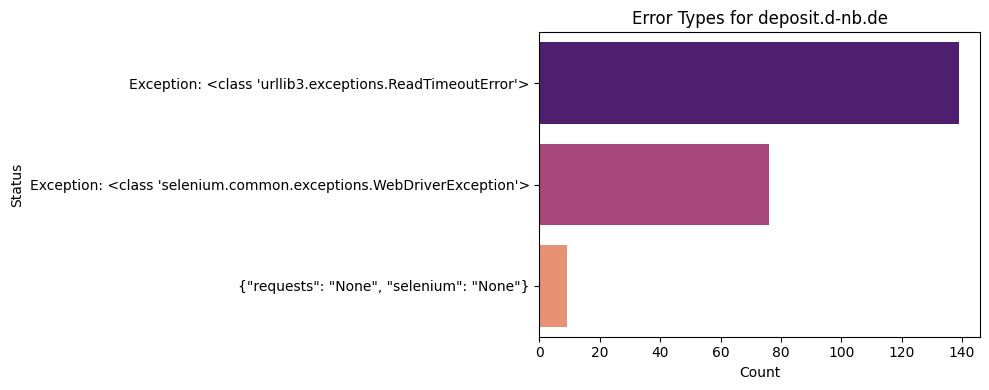

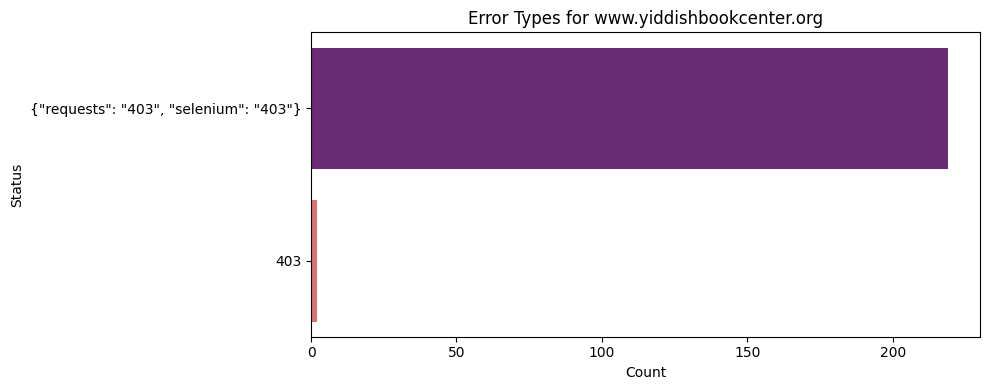

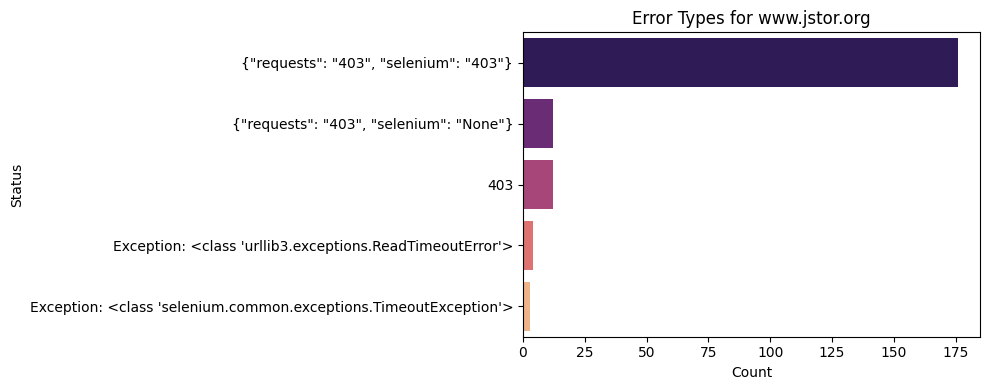

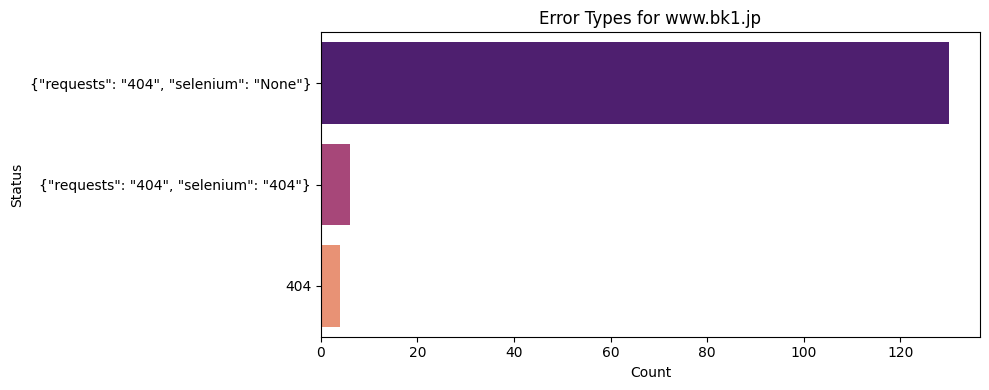

In [147]:
# Plot Separate Bar Charts

# Filter only top N domains
for domain in top_domains:
    subset = domain_error_types[domain_error_types['Domain'] == domain]

    plt.figure(figsize=(10, 4))
    sns.barplot(
        data=subset, 
        x='Error_Count', 
        y='Status', 
        hue='Status',      # Add hue
        palette='magma', 
        dodge=False,       # Prevent bars from stacking
        legend=False       # Hide the duplicate legend
    )
    plt.title(f'Error Types for {domain}')
    plt.xlabel('Count')
    plt.ylabel('Status')
    plt.tight_layout()
    plt.show()

